# C964 Predictive Model Training & Evaluation

## Setup

In [1]:
import logging

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklego.meta import ZeroInflatedRegressor

%matplotlib inline

logging.getLogger("root").setLevel(logging.ERROR)


In [2]:
# Features file manually encodes the variable type for each selected column for use in training
meta = pd.read_csv("../data/features.csv")
meta


,variable,kind
0,HDD65,numerical
1,CDD65,numerical
2,TYPEHUQ,categorical
3,CELLAR,boolean
4,BASEFIN,boolean
...,...,...
87,MORETHAN1H2O,boolean
88,FUELH2O2,categorical
89,EVCHRGHOME,boolean
90,NHSLDMEM,numerical


In [3]:
# Categorize variable by type
numerical_vars = meta.query("`kind` == 'numerical'")["variable"].tolist()
boolean_vars = meta.query("`kind` == 'boolean'")["variable"].tolist()
ordinal_vars = meta.query("`kind` == 'ordinal'")["variable"].tolist()
categorical_vars = meta.query("`kind` == 'categorical'")["variable"].tolist()

# Define target and feature variables
target_vars = ["BTUEL", "BTUNG", "BTULP", "BTUFO", "BTUWD"]
feature_vars = [col for col in list(meta["variable"]) if col not in target_vars]

# Assign features by type
numerical_features = [col for col in numerical_vars if col in feature_vars]
boolean_features = [col for col in boolean_vars if col in feature_vars]
ordinal_features = [col for col in ordinal_vars if col in feature_vars]
categorical_features = [col for col in categorical_vars if col in feature_vars]

# Display counts of features by type
print("numerical_features", len(numerical_features))
print("boolean_features", len(boolean_features))
print("ordinal_features", len(ordinal_features))
print("categorical_features", len(categorical_features))
print("targets", len(target_vars))


numerical_features 34
boolean_features 22
ordinal_features 6
categorical_features 30
targets 5


In [4]:
# Define Pandas datatypes for variables
dtype = {}
for col in categorical_vars + ordinal_vars:
    dtype[col] = "category"
for col in boolean_vars:
    dtype[col] = "boolean"
for col in numerical_vars:
    dtype[col] = "float64"

# Import survey response dataset
data = pd.read_csv(
    "../data/recs2020_public_v5.csv",
    usecols=lambda c: c in (feature_vars + target_vars),
    dtype=dtype,
    na_values=["-2"],
)

targets = data[target_vars]
data = data[feature_vars]

data.head()


,HDD65,CDD65,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,SIZEOFGARAGE,YEARMADERANGE,...,COOLCNTL,TEMPHOMEAC,H2OAPT,WHEATSIZ,FUELH2O,MORETHAN1H2O,FUELH2O2,EVCHRGHOME,NHSLDMEM,SQFTEST
0,3844.0,1679.0,2,False,<NA>,False,<NA>,1,2,4,...,1,71.0,<NA>,3,1,False,NaN,<NA>,2.0,2100.0
1,3766.0,1458.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,5,...,4,68.0,False,2,1,False,NaN,<NA>,1.0,590.0
2,3819.0,1696.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,1,70.0,True,4,1,False,NaN,<NA>,1.0,900.0
3,2614.0,1718.0,2,False,<NA>,False,<NA>,2,2,5,...,1,72.0,<NA>,3,1,False,NaN,<NA>,2.0,2100.0
4,4219.0,1363.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,2,72.0,True,2,1,False,NaN,<NA>,2.0,800.0


## Create Data Pipeline

In [5]:
def create_constant_imputer(fill_value):
    return SimpleImputer(
        strategy="constant", fill_value=fill_value, add_indicator=False
    )

def create_median_imputer():
    return SimpleImputer(strategy="median", add_indicator=False)

# Impute missing boolean values as false
preprocess_boolean = make_pipeline(
    create_constant_imputer(fill_value=False)
)

# Impute median values for select columns, impute others as constant
preprocess_numerical = ColumnTransformer(
    [
        ("median", create_median_imputer(), [
            "HDD65",
            "CDD65",
            "BEDROOMS",
            "NCOMBATH",
            "NHAFBATH",
            "TEMPHOME",
            "TEMPHOMEAC",
            "NHSLDMEM",
            "SQFTEST",
        ]),
    ],
    remainder=create_constant_imputer(fill_value=0)
)

preprocessor = ColumnTransformer(
    [
        ("numerical", preprocess_numerical, make_column_selector(dtype_include="number")),
        ("boolean", preprocess_boolean, make_column_selector(dtype_include="boolean"))
    ],
    remainder=create_constant_imputer(fill_value=-1)
)
preprocessor


ColumnTransformer(remainder=SimpleImputer(fill_value=-1, strategy='constant'),
                  transformers=[('numerical',
                                 ColumnTransformer(remainder=SimpleImputer(fill_value=0,
                                                                           strategy='constant'),
                                                   transformers=[('median',
                                                                  SimpleImputer(strategy='median'),
                                                                  ['HDD65',
                                                                   'CDD65',
                                                                   'BEDROOMS',
                                                                   'NCOMBATH',
                                                                   'NHAFBATH',
                                                                   'TEMPHOME',
                                                                   'TEMPHOMEAC',
                                                                   'NHSLDMEM',
                                                                   'SQFTEST'])]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f633c0c3b20>),
                                ('boolean',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f633be8fa60>)])

## Train and Evaluate Regression Models

Coefficient of determination (R²):
0.590 ± 0.018
Mean Absolute Error (MAE):
10303.074 ± 112.892


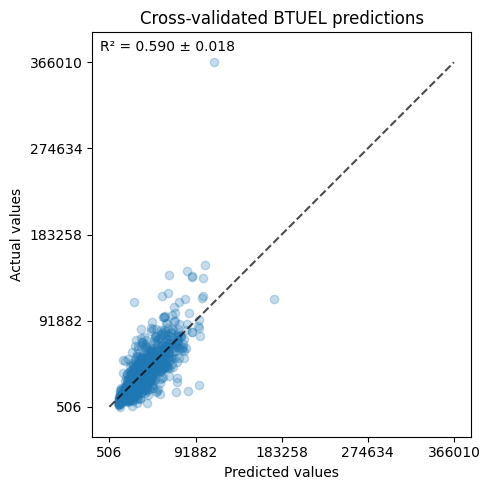

In [6]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)

def evaluate_classifier(classifier, target_var):
    """Perform 3-fold cross-validation to evaluate classifier performance"""
    target = targets[target_var]
    pipeline = make_pipeline(preprocessor, classifier)

    non_zero_mask = target > 0

    # Cross-validate zero/non-zero classification
    y_pred = cross_val_predict(
        pipeline,
        data,
        non_zero_mask,
        cv=cv,
    )

    # Print classification report
    print(classification_report(non_zero_mask, y_pred, digits=3))

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(non_zero_mask, y_pred)
    plt.show()

def evaluate_regressor(regressor, target_var):
    """Perform 3-fold cross-validation to evaluate regressor performance"""
    target = targets[target_var]
    pipeline = make_pipeline(preprocessor, regressor)

    non_zero_mask = target > 0
    non_zero_data = data[non_zero_mask]
    non_zero_targets = target[non_zero_mask]

    # Cross-validate and print mean scores across folds
    cv_results = cross_validate(
        pipeline,
        non_zero_data,
        non_zero_targets,
        cv=cv,
        scoring=["r2", "neg_mean_absolute_error"],
    )

    cv_results = pd.DataFrame(cv_results)

    scores = pd.DataFrame(
        {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
    )
    print(
        "Coefficient of determination (R²):\n"
        f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
    )
    print(
        "Mean Absolute Error (MAE):\n"
        f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
    )

    # Predict target variables with cross-validation
    y_pred = cross_val_predict(
        pipeline,
        non_zero_data,
        non_zero_targets,
        cv=cv,
    )

    # Plot cross-validated results
    _, ax = plt.subplots(figsize=(5, 5))
    _ = PredictionErrorDisplay.from_predictions(
        non_zero_targets,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.25},
        random_state=42,
    )
    ax.set_title(f"Cross-validated {target_var} predictions")
    ax.text(
        0.02,
        0.98,
        f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
    plt.tight_layout()
    plt.show()

target_var = "BTUEL"

regressor = lgb.LGBMRegressor(verbose=-1, objective="poisson", random_state=42)
evaluate_regressor(regressor, target_var)


              precision    recall  f1-score   support

       False      0.987     1.000     0.993      7393
        True      1.000     0.991     0.995     11103

    accuracy                          0.995     18496
   macro avg      0.993     0.995     0.994     18496
weighted avg      0.995     0.995     0.995     18496



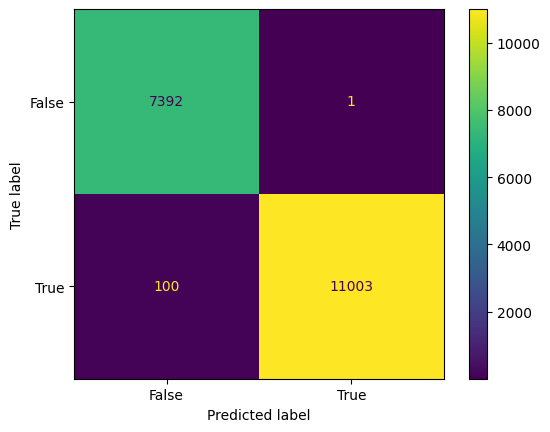

Coefficient of determination (R²):
0.606 ± 0.007
Mean Absolute Error (MAE):
17438.146 ± 316.574


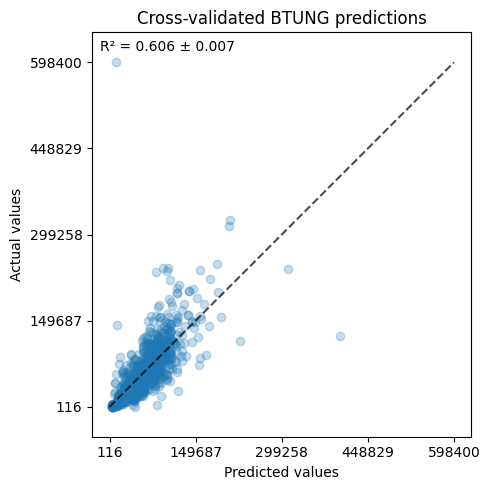

In [7]:
# Evaluate classifier and regressor for BTUNG target
target_var = "BTUNG"

classifier = lgb.LGBMClassifier(verbose=-1, objective="binary", random_state=42)
evaluate_classifier(classifier, target_var)

regressor = lgb.LGBMRegressor(verbose=-1, objective="poisson", random_state=42)
evaluate_regressor(regressor, target_var)

              precision    recall  f1-score   support

       False      0.995     1.000     0.997     16507
        True      0.996     0.961     0.978      1989

    accuracy                          0.995     18496
   macro avg      0.996     0.980     0.988     18496
weighted avg      0.995     0.995     0.995     18496



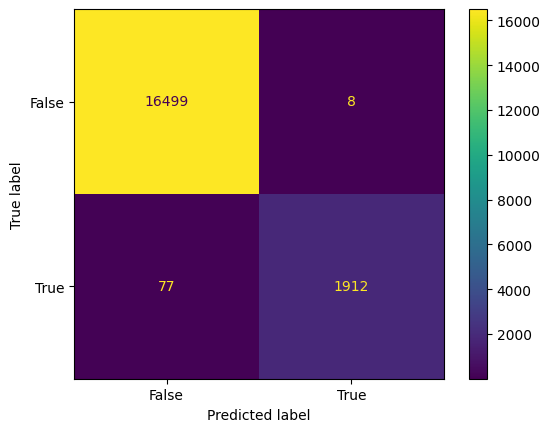

Coefficient of determination (R²):
0.627 ± 0.037
Mean Absolute Error (MAE):
14794.877 ± 367.477


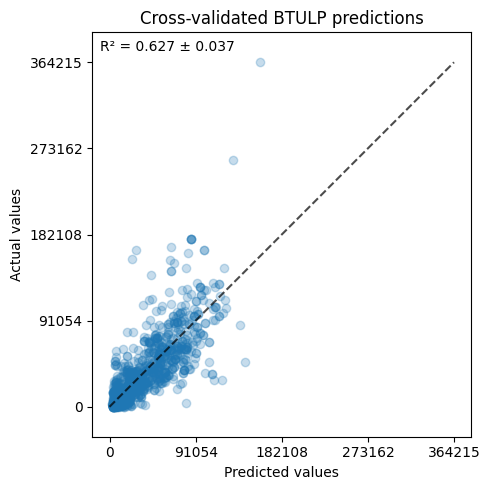

In [8]:
# Evaluate classifier and regressor for BTULP target
target_var = "BTULP"

classifier = lgb.LGBMClassifier(verbose=-1, objective="binary", random_state=42)
evaluate_classifier(classifier, target_var)

regressor = lgb.LGBMRegressor(verbose=-1, objective="poisson", random_state=42)
evaluate_regressor(regressor, target_var)

              precision    recall  f1-score   support

       False      1.000     1.000     1.000     17263
        True      0.999     0.996     0.998      1233

    accuracy                          1.000     18496
   macro avg      0.999     0.998     0.999     18496
weighted avg      1.000     1.000     1.000     18496



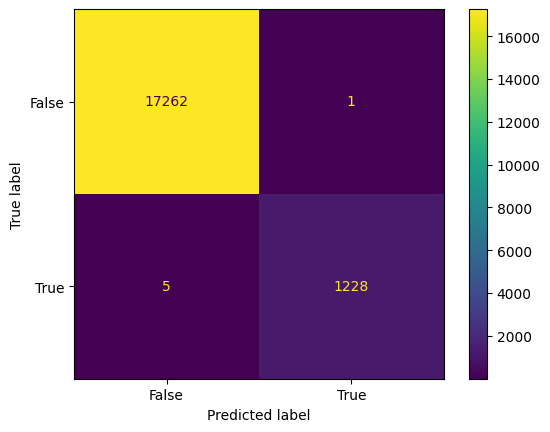

Coefficient of determination (R²):
0.441 ± 0.044
Mean Absolute Error (MAE):
25682.072 ± 1013.540


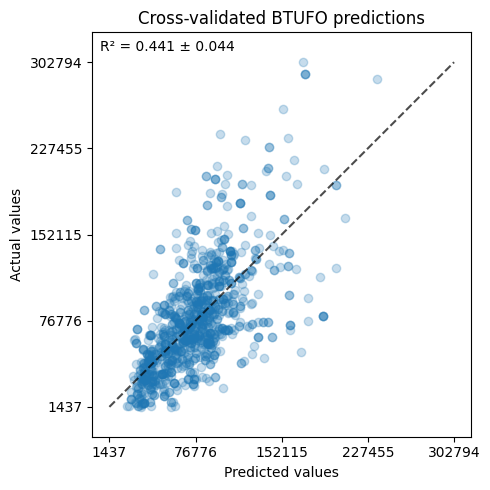

In [9]:
# Evaluate classifier and regressor for BTUFO target
target_var = "BTUFO"

classifier = lgb.LGBMClassifier(verbose=-1, objective="binary", random_state=42)
evaluate_classifier(classifier, target_var)

regressor = lgb.LGBMRegressor(verbose=-1, objective="poisson", random_state=42)
evaluate_regressor(regressor, target_var)


              precision    recall  f1-score   support

       False      1.000     1.000     1.000     16522
        True      0.998     0.999     0.999      1974

    accuracy                          1.000     18496
   macro avg      0.999     0.999     0.999     18496
weighted avg      1.000     1.000     1.000     18496



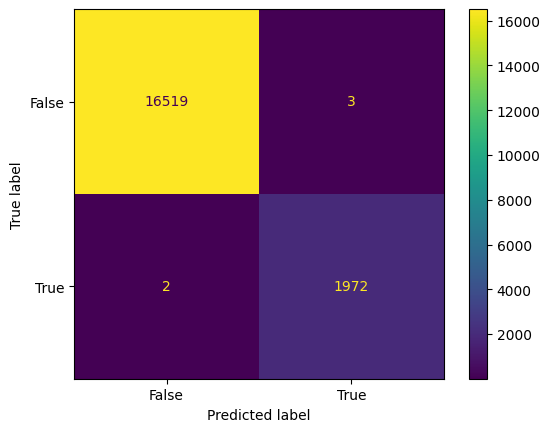

Coefficient of determination (R²):
0.422 ± 0.045
Mean Absolute Error (MAE):
18881.441 ± 1528.135


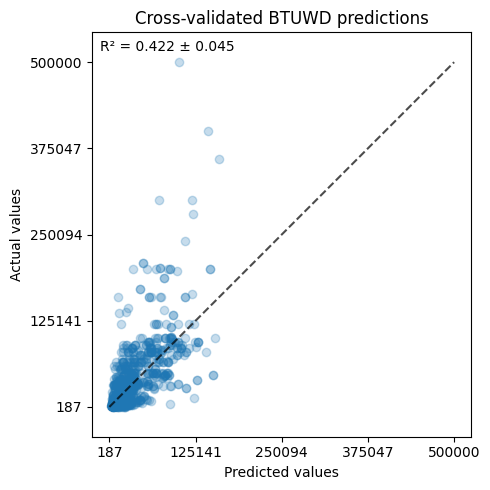

In [10]:
# Evaluate classifier and regressor for BTUWD target
target_var = "BTUWD"

classifier = lgb.LGBMClassifier(verbose=-1, objective="binary", random_state=42)
evaluate_classifier(classifier, target_var)

regressor = lgb.LGBMRegressor(verbose=-1, objective="poisson", random_state=42)
evaluate_regressor(regressor, target_var)

## Create and Export Final Model

In [11]:
# Train a multi-output model targeting all target variables
target = targets

regressor = MultiOutputRegressor(
    ZeroInflatedRegressor(
        classifier=lgb.LGBMClassifier(verbose=-1, objective="binary", random_state=42),
        regressor=lgb.LGBMRegressor(verbose=-1, objective="poisson", random_state=42),
    )
)
model = make_pipeline(preprocessor, regressor)

# Fit the model against the entire dataset
# (generalized performance has already been determined through cross-validation)
model.fit(data, target)

# Export the model for use
filename = "../model.joblib"
joblib.dump(model, filename)


['../model.joblib']